# Settings

In [1]:
%matplotlib inline

import time
import os, os.path
import random
import cv2
import glob
#import keras
import matplotlib
import matplotlib.pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf

import tqdm
#import pandas as pd
import numpy as np
import json

2021-12-23 10:52:10.500881: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

In [24]:
from src.circle_detection.hough_circle_detection import hough_circle_detection_simple
import math

In [4]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Model Selection

In [5]:
model_choice = "vgg16_fine_tune" # choices: vgg16, vgg19, resnet50

if model_choice == "vgg16_transfer":
    base_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))
    
    # Freeze model
    for layer in base_model.layers:
        layer.trainable = False
        
elif model_choice == "vgg19_transfer":
    base_model = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3))
    
    # Freeze model
    for layer in base_model.layers:
        layer.trainable = False
elif model_choice == "resnet50_transfer":
    base_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))
    
    # Freeze model
    for layer in base_model.layers:
        layer.trainable = False

elif model_choice == "vgg16_fine_tune":
    base_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))
    
    # Freeze model
    for layer in base_model.layers:
        if(layer.name.startswith("block5")):
            layer.trainable = True
        else:
            layer.trainable = False  
            
elif model_choice == "vgg19_fine_tune":
    base_model = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3))
    
    # Freeze model
    for layer in base_model.layers:
        if(layer.name.startswith("block5")):
            layer.trainable = True
        else:
            layer.trainable = False  
else:
    print("Please choose a valid model")

base_model.summary()


2021-12-23 10:52:13.507015: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-23 10:52:13.508624: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-23 10:52:13.598828: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.78GiB deviceMemoryBandwidth: 607.97GiB/s
2021-12-23 10:52:13.598939: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-23 10:52:13.604070: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-23 10:52:13.604137: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2021-1

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
# Function to create the final classification model
def layer_adder(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation="relu")(top_model)
    top_model = Dense(512, activation="relu")(top_model)
    top_model = Dense(num_classes, activation="softmax")(top_model)
    return top_model

In [7]:
droplets_head = layer_adder(base_model, 3)
droplets_model = Model(inputs = base_model.input, outputs = droplets_head)
droplets_model.compile(loss = "categorical_crossentropy",
                       optimizer = "Adam",
                       metrics = ["accuracy"])

In [8]:
# Saving the best model
checkpoint_filepath = f'models/{model_choice}_checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Handling targets

In [9]:
with open("datasets/droplets/label-data-min.json") as infile:
    label_json = json.load(infile)

In [10]:
images = []
labels = []
for image in label_json:
    
    image_filename = image["image"][24:]
    # print(image_filename)
    img = cv2.imread(f"datasets/droplets/label-data/{image_filename}")
    
    if img is None:
        print(image_filename)
    img = cv2.resize(img, (224,224))
    
    img = np.array(img, dtype=np.float32)

    # Normalise the images
    img /= 255
    
    label = image["choice"]
    
    if label == "Not_Droplet":
        label = 2
    if label == "Empty":
        label = 0
    if label == "Bacteria":
        label = 1

    
    images.append(img)
    
    labels.append(label)

images = np.array(images)
labels = np.array(labels)

In [11]:
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.30, random_state=seed_value)

In [12]:
# Computing class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(labels_train),
                                                 y=labels_train)
class_weight_dict = dict(enumerate(class_weights))

In [13]:
def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])
labels_train = one_hot(labels_train, 3)

# Training

In [14]:
tf.config.run_functions_eagerly(True)

In [15]:
history = droplets_model.fit(x=images_train, y=labels_train, validation_split=0.3, epochs=200, 
                             class_weight=class_weight_dict, callbacks=[model_checkpoint_callback])

/home/l.nuic/.conda/envs/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
2021-12-23 10:52:19.121490: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-23 10:52:19.156118: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2099800000 Hz
2021-12-23 10:52:19.219657: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


Epoch 1/200


2021-12-23 10:52:20.268506: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


37/37 [==============================] - 14s 315ms/step - loss: 1.2110 - accuracy: 0.4983 - val_loss: 0.4542 - val_accuracy: 0.8532
Epoch 2/200
37/37 [==============================] - 10s 274ms/step - loss: 0.5370 - accuracy: 0.8623 - val_loss: 0.1244 - val_accuracy: 0.9663
Epoch 3/200
37/37 [==============================] - 10s 275ms/step - loss: 0.3788 - accuracy: 0.9297 - val_loss: 0.1658 - val_accuracy: 0.9663
Epoch 4/200
37/37 [==============================] - 10s 275ms/step - loss: 0.3786 - accuracy: 0.9371 - val_loss: 0.2591 - val_accuracy: 0.9246
Epoch 5/200
37/37 [==============================] - 10s 275ms/step - loss: 0.2631 - accuracy: 0.9330 - val_loss: 0.5597 - val_accuracy: 0.7778
Epoch 6/200
37/37 [==============================] - 10s 275ms/step - loss: 0.3487 - accuracy: 0.8933 - val_loss: 0.1415 - val_accuracy: 0.9484
Epoch 7/200
37/37 [==============================] - 10s 274ms/step - loss: 0.2415 - accuracy: 0.9174 - val_loss: 0.1731 - val_accuracy: 0.9246
Epoc

In [17]:
droplets_model.load_weights(f'models/{model_choice}_checkpoint')
droplets_model.save(f'models/{model_choice}')

2021-12-23 11:34:48.949249: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/vgg16_fine_tune/assets


# Inference

In [19]:
droplets_model = tf.keras.models.load_model(f'models/{model_choice}')

In [20]:
labels_test_predict = droplets_model.predict(images_test)

/home/l.nuic/.conda/envs/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [21]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(labels_test, np.argmax(labels_test_predict, axis=1))

print('Confusion Matrix\n')
print(confusion)

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(labels_test, np.argmax(labels_test_predict, axis=1), target_names=['empty', 'full', 'not_a_droplet']))

Confusion Matrix

[[106  19   1]
 [ 12 529   0]
 [  1   4  48]]

Classification Report

               precision    recall  f1-score   support

        empty       0.89      0.84      0.87       126
         full       0.96      0.98      0.97       541
not_a_droplet       0.98      0.91      0.94        53

     accuracy                           0.95       720
    macro avg       0.94      0.91      0.92       720
 weighted avg       0.95      0.95      0.95       720



In [22]:
droplets_model.save(f'models/{model_choice}')

INFO:tensorflow:Assets written to: models/vgg16_fine_tune/assets


/home/l.nuic/.conda/envs/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


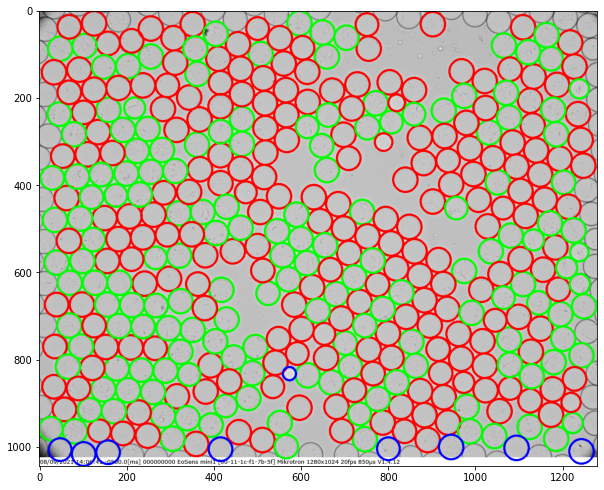

In [25]:
test_img_path = "datasets/droplets/test/original/2_hrs_lambda_10_c0000000000.jpg"

test_img = cv2.imread(test_img_path)
output_test_img = test_img.copy()

test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

circles_test_img = hough_circle_detection_simple(test_img)

if circles_test_img is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circlesRound_test_img = np.round(circles_test_img[0, :]).astype("int")
    # loop over the (x, y) coordinates and radius of the circles
    
    height, width = test_img.shape[:2]
    
    for (x, y, r) in circlesRound_test_img:
        if (x - r < 0 or x + r > width or y - r < 0 or y + r > height):
            continue
        
        
        x_min = math.floor(max(x - r, 0))
        x_max = math.ceil(min(x + r, width))
        y_min = math.floor(max(y - r, 0))
        y_max = math.ceil(min(y + r, height))

        droplet = test_img[y_min:y_max, x_min:x_max]
        droplet = cv2.resize(droplet, (224,224))
        
        mask = np.zeros_like(droplet)
        mask = cv2.circle(mask, (112, 112), 112, (255,255,255), -1)
        masked_droplet = cv2.bitwise_and(droplet, mask)
    
        masked_droplet = np.array(masked_droplet, dtype=np.float32)

        # Normalise the images
        masked_droplet /= 255
        
        masked_droplet_3 = np.zeros((1, 224, 224, 3))
        masked_droplet_3[0, :, :, 0] = masked_droplet
        masked_droplet_3[0, :, :, 1] = masked_droplet
        masked_droplet_3[0, :, :, 2] = masked_droplet
        
        
        #plt.imshow(masked_droplet)
    
        #cv2.circle(output_test_img, (x, y), r, (0, 255, 0), 4)
        prediction = droplets_model.predict(masked_droplet_3)
        
        best_i = np.argmax(prediction)
        
        cv2.circle(output_test_img, (x, y), r, (255 * int(best_i == 0), 255 * int(best_i == 1), 255 * int(best_i == 2)), 4)
        
    plt.figure(figsize=(10, 10))
    plt.imshow(output_test_img)
else:
    print ('No circles found')